In [0]:
import pandas as pd
import numpy as np
import json
from pprint import pprint
from scipy.stats import hypergeom

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
categorical_palette = sns.color_palette(["#88d5d4",
"#f7cb6c",
"#f3a5ac",
"#619c80",
"#df7670",
"#b19fc9"], n_colors=6)
continuous_palette = sns.color_palette("crest")
sns.set(font_scale=1.3, style='whitegrid', palette='pastel')
# sns.set_palette(continuous_palette)

In [0]:
overlapping_categories = json.load(open('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/overlapping_categories.json', 'r'))

ground_truth = pd.read_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/ground_truth_marker_genes_tidy.csv')
ge_computed_logcpm = pd.read_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/ge_computed_logcpm_marker_genes_tidy.csv')
ge_computed_rankit = pd.read_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/ge_computed_rankit_marker_genes_tidy.csv')

In [0]:
n_expressed_genes = json.load(open('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/n_expressed_genes.json', 'r'))

In [0]:
def compute_hypergeom_pval(ground_truth, comparison, tp, n_expressed_genes_tissue_cl):
    '''
    Pull the p-val (i.e., cdf value) from a hypergeometric distribution. This estimates the probability of retrieving <= this many marker genes, given the total number of genes in the dataset; the number of ground truth markers in that dataset; the number of genes returned by the algo; and the number of true positives in those results.
    '''

    k = len(tp) # n true positives marker genes recovered by algo
    N = len(comparison) # n marker genes returned by algo

    n = len(ground_truth) # n marker genes in ground truth
    M = n_expressed_genes_tissue_cl # total number of genes in data

    return hypergeom.sf(k, M, n, N)

In [0]:
def compute_metrics(ground_truth, comparison, tissue, cl, n_expressed_genes_tissue_cl): 
    '''
    For two sets of marker genes, compute the sensitivity, specificity, and p-value (from a hypergeometric distribution).
    Return as a dictionary.
    '''
    # true positive: in both ground truth and comparison
    tp = set(ground_truth).intersection(set(comparison))

    # false negative:in ground truth, not in comparison
    fn = set(ground_truth).difference(set(comparison))

    # false positive: in comparison, not in ground truth
    fp = set(comparison).difference(set(ground_truth))

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) > 0 or len(fp) > 0) else 0.
    recall = len(tp) / (len(tp) + len(fn)) if (len(tp) > 0 or len(fn) > 0) else 0.
    if (precision == 0 and recall == 0): 
        f = 0
    else:
        f = (2 * precision * recall) / (precision + recall)

    pval = compute_hypergeom_pval(ground_truth, comparison, tp, n_expressed_genes_tissue_cl)

    return {'precision': precision, 'recall': recall, 'f': f, 'tissue': tissue, 'cl': cl, 'pval': pval}

In [0]:
def calc_category_metrics(ground_truth_df, comparison_dfs, overlapping_categories=overlapping_categories, n_expressed_genes=n_expressed_genes):
    '''
    For each set of marker genes (rankit, logcpm), compute metrics comparing them to the ground truth. 
    Record these metrics, along with which set of marker genes we're comparing with, in an aggregated data frame.
    '''
    results = []

    for tissue, cls in overlapping_categories.items():
        n_expressed_genes_tissue = n_expressed_genes[tissue]

        for cl in cls:
            ground_truth_slice = ground_truth_df.loc[(ground_truth_df['tissue'] == tissue) & (ground_truth_df['cl'] == cl)]['gene']
            n_expressed_genes_tissue_cl = int(n_expressed_genes_tissue[cl])

            for dataset_name, df in comparison_dfs.items():
                df_slice = df.loc[(df['tissue'] == tissue) & (df['cl'] == cl)]
                
                top_n_df_slice = df_slice.sort_values('marker_score', ascending=False)['gene'][:25]
                if len(top_n_df_slice) < 4:
                    continue
                metrics = compute_metrics(ground_truth_slice, top_n_df_slice, tissue, cl, n_expressed_genes_tissue_cl)
                metrics['dataset'] = dataset_name
                results.append(metrics)

    results = pd.DataFrame.from_records(results)
    return results

In [0]:
results_all_scores = calc_category_metrics(ground_truth, {'Quantile\nnormalized': ge_computed_rankit, 'Ln(CPTT+1)\nnormalized': ge_computed_logcpm})

results_all_scores.to_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/marker_gene_recall.csv')

1 25 9 34065
1 25 9 34065
6 25 13 30487
6 25 13 30487
3 25 9 24306
4 25 9 24306
3 25 7 16513
3 25 7 16513
5 25 9 22309
5 25 9 22309
5 25 12 41871
6 25 12 41871
2 25 8 32722
3 25 8 32722
0 25 6 0
0 25 6 0
1 25 4 24818
1 25 4 24818
0 25 4 0
0 25 4 0
1 25 5 24995
1 25 5 24995
6 25 19 18050
6 25 19 18050
6 25 11 23141
7 25 11 23141
3 11 35 19241
3 11 35 19241
0 4 5 27913
0 7 5 27913
1 25 6 17069
1 25 6 17069
0 7 8 26069
2 11 8 26069
4 25 4 22876
4 25 4 22876
1 25 8 18483
1 25 8 18483
1 25 5 0
0 25 5 0
3 25 16 25964
3 25 16 25964
2 25 9 16534
1 25 9 16534
3 25 19 0
3 25 19 0
6 25 7 13034
6 25 7 13034
1 25 6 22715
1 25 6 22715
5 15 5 19309
5 16 5 19309
3 25 5 16325
3 25 5 16325
7 25 7 17233
7 25 7 17233
8 25 9 19203
9 25 9 19203
3 25 8 24512
3 25 8 24512
2 24 11 16814
1 18 11 16814
5 17 10 20742
7 25 10 20742
6 25 6 19188
6 25 6 19188
2 25 4 19965
2 25 4 19965
1 25 4 26636
1 25 4 26636
4 25 6 23182
4 25 6 23182
3 25 5 20241
3 25 5 20241
1 25 7 23169
1 25 7 23169
4 25 6 22479
3 25 6 22479
1 1

In [0]:
def plot_metrics_summary(results, title='', fp=None):

    recall_results = results[['tissue', 'cl', 'dataset', 'recall']]
    flattened_results = results_all_scores.melt(id_vars=['tissue', 'cl', 'dataset'], var_name='metric', value_vars=['recall'], value_name='value')

    fig, ax = plt.subplots(figsize=(6,4))

    sns.boxplot(x="value", y="dataset", data=flattened_results, 
                color='whitesmoke',
                whis=[0, 100], width=0.3, ax=ax)
    sns.stripplot(x="value", y="dataset", hue='tissue', data=flattened_results,
                linewidth=0.3, size=6, alpha=0.8, jitter=False, dodge=True, ax=ax)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    ax.set(xlabel="")
    ax.set(title=title)
    sns.despine(trim=True, left=True)

    plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))

    if fp:
        plt.savefig(fp, dpi=300, format='png', pad_inches=1, bbox_inches='tight')
    plt.show()

    print('Mean recall:', results[['recall', 'dataset']].groupby('dataset').agg('mean').round(2))

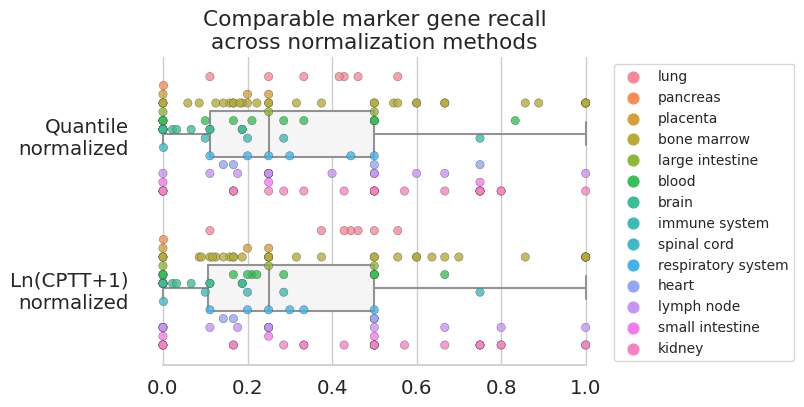

Mean recall:                         recall
dataset                       
Ln(CPTT+1)\nnormalized    0.33
Quantile\nnormalized      0.33


In [0]:
plot_metrics_summary(results_all_scores, title='Comparable marker gene recall\nacross normalization methods', fp='/dbfs/FileStore/users/sbell/2023-08_norm_characterization/marker_gene_recall.png')


In [0]:
pvals = results_all_scores['pval']
min_pval = pvals.min()
max_pval = pvals.max()
print(min_pval, max_pval)

0.0 0.03959842441362701
